In [95]:
pip install gym numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
# Baseline SoTA reward function
def SoTARewardFunction(observation, action):
    x, _, theta, _ = observation
    
    if abs(theta) > np.deg2rad(15) or abs(x) > 2.4:
        return 0
    
    return 1

# Example LLM-generated reward functions
def LLMRewardFunction1(observation, action):
    x, _, angle, _ = observation
    reward = 1.0 - abs(angle) - 0.5 * abs(x)
    return max(0, reward)

def LLMRewardFunction2(observation, action):
    x, _, angle, _ = observation
    reward = 1.0
    
    if abs(x) > 2.4 or abs(angle) > 0.2:
        reward = -10.0
    else:
        reward += 10.0 / (1.0 + abs(angle))
        reward += 5.0 / (1.0 + abs(x))
    
    return int(reward)


#---

# Train the agent using Q-learning
def train(env, agent, reward_model, episodes=500):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()[0]
        state = agent.discretize(observation)
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_observation, reward, done, _, _ = env.step(action)
            adjusted_reward = reward_model(next_observation, reward)
            next_state = agent.discretize(next_observation)
            agent.update(state, action, adjusted_reward, next_state)
            state = next_state
            total_reward += adjusted_reward
        rewards.append(total_reward)
    return rewards



# episodes = 10000
# baselineRewards = train(env, agent, SoTARewardFunction, episodes)
# LLM1Rewards = train(env, agent, LLMRewardFunction1, episodes)
# LLM2Rewards = train(env, agent, LLMRewardFunction2, episodes)

# # Plot results
# plt.plot(np.arange(episodes), LLM2Rewards, label="2nd LLM-Generated Reward Model")
# plt.plot(np.arange(episodes), baselineRewards, label="Custom Baseline Reward Model")
# plt.plot(np.arange(episodes), LLM1Rewards, label="1st LLM-Generated Reward Model")

# plt.xlabel("Episodes")
# plt.ylabel("Total Reward")

# plt.title("Reward Comparison over Time")

# plt.legend()
# plt.show()


c:\Users\samdd\anaconda3\envs\gymenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


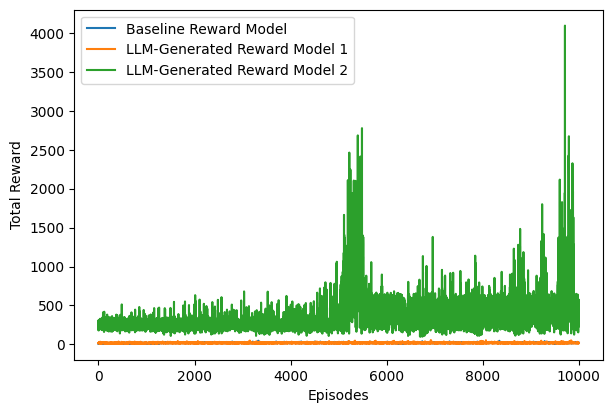

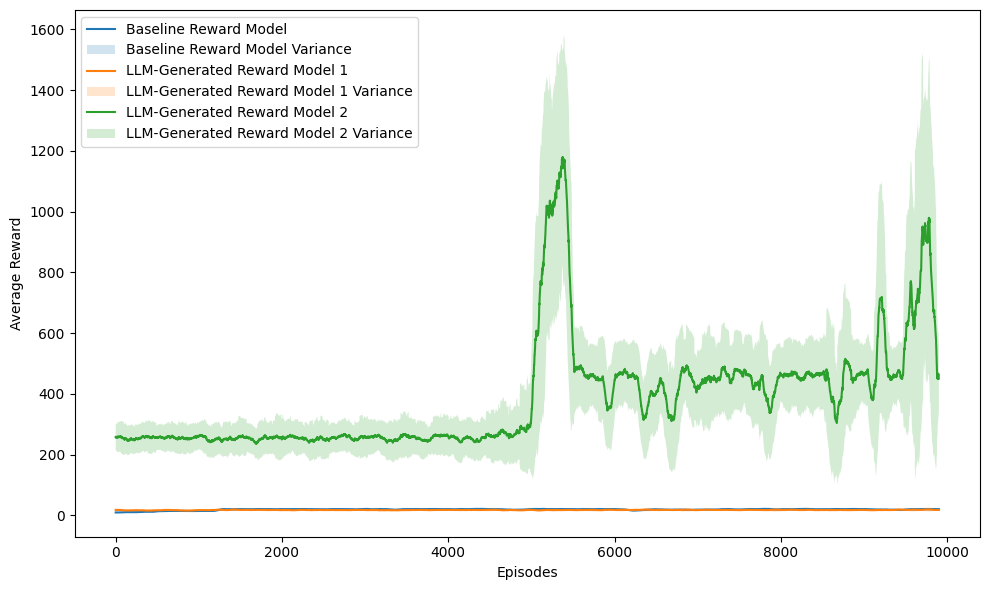

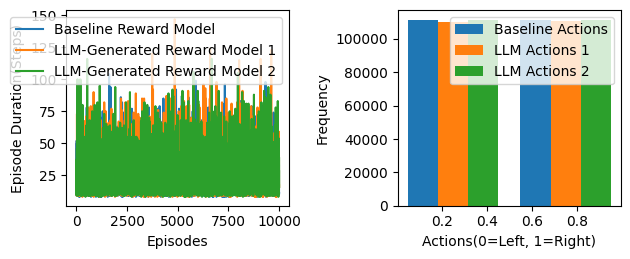

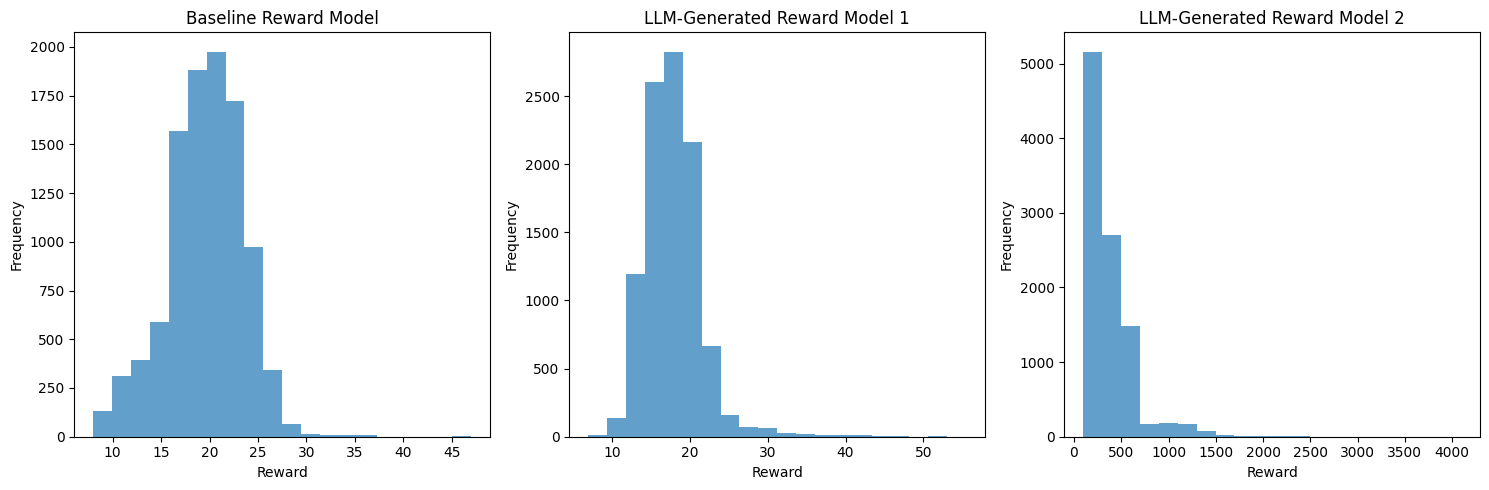

In [5]:
# Takes ~ 60 second to run
from cartPoleShared import QLearningAgent


env = gym.make('CartPole-v1')
agent = QLearningAgent(env)


#This is temporary until I fix the error with the update function not being defined inthe calss
def update(self, state, action, reward, next_state):
    best_next_action = np.argmax(self.q_table[next_state])
    td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
    td_error = td_target - self.q_table[state][action]
    self.q_table[state][action] += self.learning_rate * td_error

QLearningAgent.update = update




def movingAverageAndStd(data, windowSize=100):
    average = np.convolve(data, np.ones(windowSize) / windowSize, mode='valid')
    std = [np.std(data[i:i+windowSize]) for i in range(len(data) - windowSize + 1)]
    return average, std




# List of reward functions to abstract repeated calls
reward_functions = [
    ("Baseline Reward Model", SoTARewardFunction),
    ("LLM-Generated Reward Model 1", LLMRewardFunction1),
    ("LLM-Generated Reward Model 2", LLMRewardFunction2)
]

# Store results in a dictionary
rewards_dict = {}

# Run experiments for each reward function
episodes = 10000
for label, reward_fn in reward_functions:
    rewards_dict[label] = train(env, agent, reward_fn, episodes)


plt.figure(figsize=(15, 10))


#Total Reward Comparison
plt.subplot(2, 2, 1)
for label, rewards in rewards_dict.items():
    plt.plot(np.arange(episodes), rewards, label=label)


plt.xlabel("Episodes")
plt.ylabel("Total Reward")

plt.legend()

# 2.Running Average of Rewards

# avgBaseline, stdBaseline = movingAverageAndStd(baselineRewards, windowSize=100)
# avgLLM1, stdLLM1 = movingAverageAndStd(LLM1Rewards, windowSize=100)
# avgLLM2, stdLLM2 = movingAverageAndStd(LLM2Rewards, windowSize=100)

plt.figure(figsize=(10, 6))


for label, rewards in rewards_dict.items():
    avg, std = movingAverageAndStd(rewards, windowSize=100)
    plt.plot(np.arange(len(avg)), avg, label=label)
    plt.fill_between(np.arange(len(avg)), avg - std, avg + std, alpha=0.2, label=f"{label} Variance")


plt.xlabel("Episodes")
plt.ylabel("Average Reward")


plt.legend()
plt.tight_layout()
plt.show()

# 3. Episode Duration
def episodeDuration(env, rewardModel, episodes=500):
    durations = []
    for episode in range(episodes):
        observation = env.reset()
        done = False
        duration = 0

        while not done:
            action = env.action_space.sample()
            observation, reward, done, _, _ = env.step(action)
            duration += 1  
        durations.append(duration)

    return durations

# Get the episode durations
durations_dict = {label: episodeDuration(env, reward_fn, episodes) for label, reward_fn in reward_functions}


# Plot Episode Duration
plt.subplot(2, 2, 3)
for label, durations in durations_dict.items():
    plt.plot(np.arange(episodes), durations, label=label)


plt.xlabel("Episodes")
plt.ylabel("Episode Duration(Steps)")
plt.legend()

# 4.action distribution
def getActionDistribution(env, rewardModel, episodes):
    actions = []
    for episode in range(episodes):
        observation = env.reset()
        done = False

        while not done:
            action = env.action_space.sample() 
            actions.append(action)
            observation, _, done, _, _ = env.step(action)

    return actions

baselineActions = getActionDistribution(env, SoTARewardFunction, episodes)
llmActions1 = getActionDistribution(env, LLMRewardFunction1, episodes)
llmActions2 = getActionDistribution(env, LLMRewardFunction2, episodes)

plt.subplot(2, 2, 4)
plt.hist([baselineActions, llmActions1, llmActions2], label=["Baseline Actions", "LLM Actions 1", "LLM Actions 2"], bins=2)

plt.xlabel("Actions(0=Left, 1=Right)")
plt.ylabel("Frequency")

plt.legend()
plt.tight_layout()
plt.show()

# 5. Reward Distribution
plt.figure(figsize=(15, 5))

# Plot for Baseline Rewards
for i, (label, rewards) in enumerate(rewards_dict.items(), 1):
    plt.subplot(1, 3, i)
    plt.hist(rewards, bins=20, alpha=0.7)
    plt.title(label)
    plt.xlabel("Reward")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# 6. Success Rate Calc
# successThreshold = 200

# baselineSuccessRate = sum([1 if r >= successThreshold else 0 for r in baselineRewards]) / episodes
# llmSuccessRate1 = sum([1 if r >= successThreshold else 0 for r in LLM1Rewards]) / episodes
# llmSuccessRate2 = sum([1 if r >= successThreshold else 0 for r in LLM2Rewards]) / episodes

# print(f"Baseline Success Rate: {baselineSuccessRate * 100:.2f}%")
# print(f"LLM-Generated Success Rate 1: {llmSuccessRate1 * 100:.2f}%")
# print(f"LLM-Generated Success Rate 2: {llmSuccessRate2 * 100:.2f}%")



In [11]:



def visualizeSuccessfulRuns(env, rewards_dict, durations_dict):
    
    # longest_runs_indices = np.argsort(durations)[-20:]  

    env = gym.make('CartPole-v1', render_mode="human")
    agent = QLearningAgent(env)

    for rewardModelName, rewards in rewards_dict.items():
        durations = durations_dict[rewardModelName]
        longest_runs_indices = np.argsort(durations)[-20:] # Get the indices of the top 20 longest runs

        for idx in longest_runs_indices:
            # print(f"Duration: {durations[idx]}, Reward: {rewards[idx]}")



            observation, _ = env.reset()
            state = agent.discretize(observation)
            done = False


            # print(f"{rewardModelName} - Run {idx+1}")

            while not done:
                action = agent.choose_action(state)
                next_observation, reward, done, _, _ = env.step(action)
                next_state = agent.discretize(next_observation)
                state = next_state

                # Render environment
                env.render()

                time.sleep(0.01)

        print(f"Next Model: {rewardModelName}")

    env.close()




visualizeSuccessfulRuns(env, rewards_dict, durations_dict)


c:\Users\samdd\anaconda3\envs\gymenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Next Model: Baseline Reward Model
Next Model: LLM-Generated Reward Model 1
Next Model: LLM-Generated Reward Model 2


In [100]:
#Maybe run many instances of reward models generated by Claude. Compare, with SoTA as baseline

Can also add an explainability metric


Prompt Engineering:

Keep a log of the interaction with Claude. To see the developemnt. (See how these perform, run compute experiements)


Eventually:(These can be developed by Claude)
Adaptive learning rate 
Adaptive Reward Function



Adaptive reward function for changes in enviornment. For example change the weight of the pole, add friction. How does the reward function adapt?





